# Contents
[Data acquisition](#Data-acquisition)<br>
[Data exploration](#Data-exploration)<br>
[Data exploration on mean and variance](#Data-exploration-on-mean-and-variance)<br>
[Data exploration with PCA and t_SNE ](#Data-exploration-with-PCA-and-t_SNE )<br>
[Data Preprocessing](#Data-Preprocessing)<br>
[SVM](#SVM)<br>
[Logistic Regression](#Logistic-Regression)<br>
[Random Forest](#Random-Forest)<br>
[KNN](#KNN)<br>
[Ridge](#Ridge)<br>
[Neural Network](#Neural-Network)<br>
[Neural Network Full Dataset](#Neural-Network-Full-Dataset)<br>
[Neural Network Prediction Results](#Neural-Network-Prediction-Results)<br>

In [1]:
!pip install kaggle

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile
import json
import pickle
import os, glob, time, copy, random, zipfile
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import numpy as np 
import pandas as pd
import seaborn as sb

import matplotlib
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.use("agg")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
from torch.utils.data import TensorDataset, DataLoader,Dataset

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
def image_gs_scale(typ,num):
    directory=os.getcwd()+'/train/'
    for i in range(num):
        img=Image.open(directory+typ+'.'+str(i)+'.jpg').convert('L')
        img=img.resize((WIDTH, HEIGHT))
        img.save('reduced_size/gs_'+typ+'.'+str(i)+'.jpg')     
    
def get_sorted_file_names(directory):
    filelist = glob.glob(directory + '/*')
    sortlist = sorted(filelist,key=KEY)
    final_list = []
    for e in sortlist:
        if 'cat' in e:
            final_list.append(e)
    for e in sortlist:
        if 'dog' in e:
            final_list.append(e)
    return final_list

def KEY(element):
    if 'cat' in element:
        return int(element.split('cat.')[1].split('.')[0])
    else:
        return int(element.split('dog.')[1].split('.')[0]) 
          

def display_image(image_data,row,col,title):
    plt.figure(figsize=(10,10)) 
    for i in range(len(image_data)):
        plt.subplot(row,col,i+1)   
        plt.imshow(image_data[i])
        plt.title(title[i],fontsize=10)
    plt.show()
    
# The function generates a scatter plot with 2 colors corresponding to cats and dogs
# x is a 2D array containing the output of PCA or t-SNE
# colors is a 1-D numpy array containing the labels of the dataset
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sb.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)], alpha=0.1)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [4]:
# global variable: image size
WIDTH = 60
HEIGHT = 60

# Data acquisition
[Back to top](#Contents)<br>

In order to run the block of code bellow, 4 steps are required:

1. Install kaggle with the command 'pip install kaggle'

2. Sign up for a Kaggle account

3. Go to the 'Account' tab of your user  profile and select 'Create API Token'. This will trigger the download of kaggle.json

4. Place this file in the location ~/.kaggle/kaggle.json

For detailed instruction, please refer to this link:
https://github.com/Kaggle/kaggle-api

In [5]:
api = KaggleApi()
api.authenticate()
api.competition_download_file('dogs-vs-cats-redux-kernels-edition','test.zip')
api.competition_download_file('dogs-vs-cats-redux-kernels-edition','train.zip')

 99%|██████████████████████████████████████████████████████████████████████████████ | 268M/271M [00:08<00:00, 26.7MB/s]

100%|███████████████████████████████████████████████████████████████████████████████| 271M/271M [00:08<00:00, 33.8MB/s]


100%|██████████████████████████████████████████████████████████████████████████████▊| 542M/544M [00:18<00:00, 21.5MB/s]

100%|███████████████████████████████████████████████████████████████████████████████| 544M/544M [00:18<00:00, 30.6MB/s]


In [6]:
with ZipFile('test.zip', 'r') as zip: 
    zip.extractall() 
with ZipFile('train.zip', 'r') as zip:   
    zip.extractall()

#### reduce image size and grey scale

In [7]:
# create a new directory to store the resized grey_scale image
path = os.getcwd() + '/reduced_size'
os.mkdir(path)

In [8]:
# resize, grey scale all train images and save them into the directory 'reduced_size'
image_gs_scale('cat',12500)
image_gs_scale('dog',12500)

# Data exploration
[Back to top](#Contents)<br>

In [9]:
# load all grey scale images
grey_file_names = get_sorted_file_names('reduced_size')
x_grey = np.array([np.array(Image.open(fname)) for fname in grey_file_names])

In [10]:
# load all original images
original_file_names = get_sorted_file_names('train')
x_original = np.array([np.array(Image.open(fname)) for fname in original_file_names])

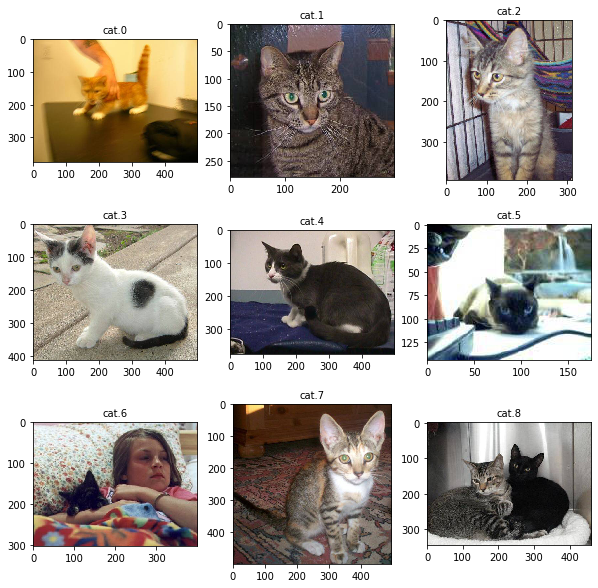

In [11]:
# display the first 9 original images
l_title = []
for i in range(9):
    l_title.append('cat.'+str(i))
display_image(x_original[:9],3,3,l_title)

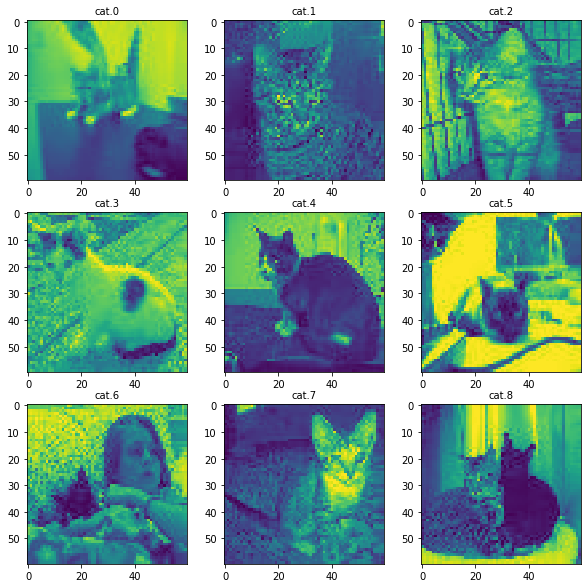

In [12]:
# display the first 9 grey-scale images
l_title = []
for i in range(9):
    l_title.append('cat.'+str(i))
display_image(x_grey[:9],3,3,l_title)

The resized and grey-scaled images are blurrer than the original images, but the animals in most of these images are still recognizable

In [13]:
del(x_original)
del(original_file_names)

# Data exploration on mean and variance
[Back to top](#Contents)<br>

In [14]:
# initialize some variables to be used in data exploration
cat = x_grey[:12500]
cat_mean = np.mean(cat,axis=0)
cat_var = np.var(cat,axis=0)
cat_mean_flat = cat_mean.flatten()
cat_var_flat = cat_var.flatten()
dog = x_grey[12500:]
dog_mean = np.mean(dog,axis=0)
dog_var = np.var(dog,axis=0)
dog_mean_flat = dog_mean.flatten()
dog_var_flat = dog_var.flatten()

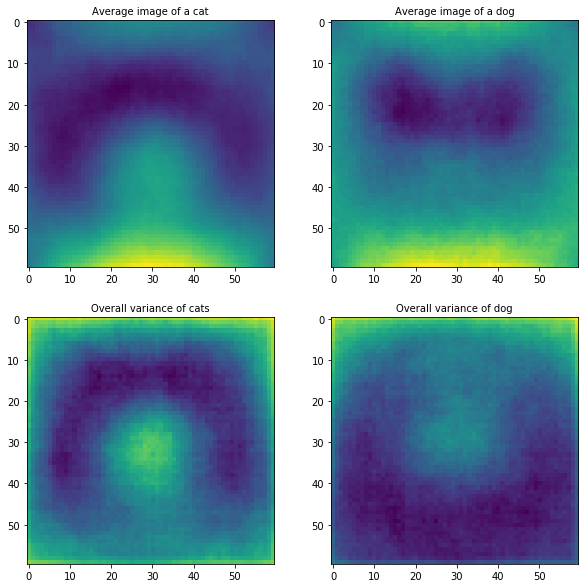

In [15]:
l = []
l.append(cat_mean)
l.append(dog_mean)
l.append(cat_var)
l.append(dog_var)
l_title = ['Average image of a cat', 'Average image of a dog', 'Overall variance of cats','Overall variance of dog']
display_image(l,2,2,l_title)

                    The brighter the region, the higher the variance

We can no longer see any dog and cat from the average images. The dog images are quite different from one another. The dogs were at different positions in the images. They have different postures, and the backgrounds were also different. The same goes for cats.

From the overall variance, we can see the parts of the images that are similiar from the dark region. 

Text(0.5, 1.0, 'Variance of each pixel: Dog')

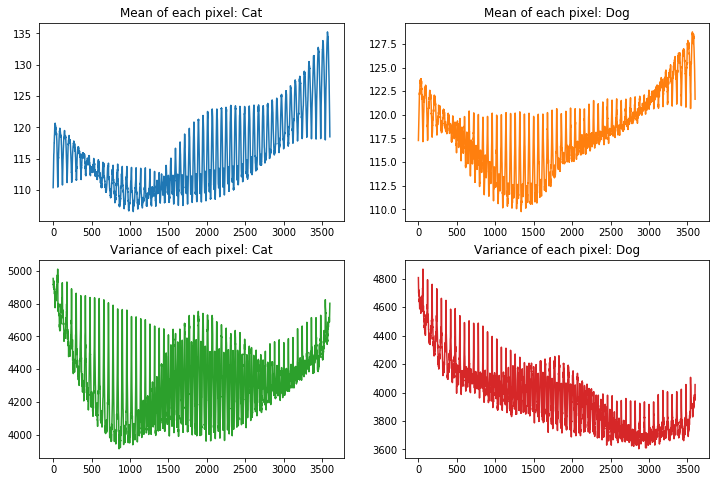

In [16]:
# set x-axis for the plots
x_axis = []
for i in range(WIDTH * HEIGHT):
    x_axis.append(i+1)    

# set y-axises for the plots
y_axis_cat_mean = []
for value in cat_mean_flat:
    y_axis_cat_mean.append(value)
y_axis_dog_mean = []
for value in dog_mean_flat:
    y_axis_dog_mean.append(value)
y_axis_cat_var = []
for value in cat_var_flat:
    y_axis_cat_var.append(value)
y_axis_dog_var = []
for value in dog_var_flat:
    y_axis_dog_var.append(value)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(x_axis, y_axis_cat_mean)
axs[0, 0].set_title('Mean of each pixel: Cat')
axs[0, 1].plot(x_axis, y_axis_dog_mean, 'tab:orange')
axs[0, 1].set_title('Mean of each pixel: Dog')
axs[1, 0].plot(x_axis, y_axis_cat_var, 'tab:green')
axs[1, 0].set_title('Variance of each pixel: Cat')
axs[1, 1].plot(x_axis, y_axis_dog_var, 'tab:red')
axs[1, 1].set_title('Variance of each pixel: Dog')

From the average pixel values, we can further see that the dog and cat images are different in terms of the average pixel values. However, the average pixel values of dogs and cats also seem to follow the same trend: decrease, then increase greatly.

The variance of cats and dogs across all pixels are very different. One interesting obervation on the variance of dog images is that as we move from the top to the bottom of the dog images, the dog images get more similiar with one another

# Data exploration with PCA and t_SNE 
[Back to top](#Contents)<br>

In [17]:
x_grey.shape

(25000, 60, 60)

In [18]:
x_grey = x_grey.reshape(25000,3600)

In [19]:
# z-scoring
x_grey = x_grey.astype('float64') 
x_grey -= x_grey.mean(axis=0)
x_grey /= np.std(x_grey,axis=0)

In [20]:
# set labels: cat = 0, dog = 1
label = np.zeros(25000)
label[12500:] = 1

In [21]:
sb.set_style('darkgrid')
sb.set_palette('muted')
sb.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
# set a random state
RS = 123

In [22]:
x = x_grey
y = label
del(x_grey)
del(label)
print(np.unique(y))

[0. 1.]


#### PCA

PCA done! Time elapsed: 21.16798186302185 seconds


Text(0.5, 1.0, 'Percentage of data variances captured by the first 50 principal directions')

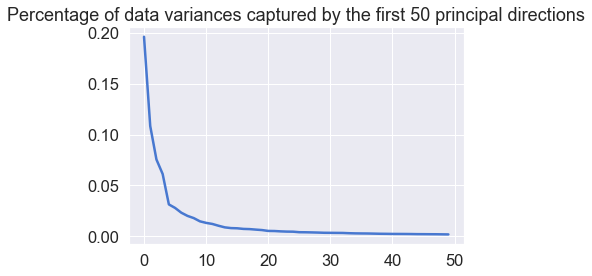

In [23]:
# implement PCA

time_start = time.time()
n = 1000
pca = PCA(n_components=n)
pca_result = pca.fit_transform(x)

print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

# plot graph of Percentage of data variances captured against number of principle directions

x_axis = []
for i in range(50):
    x_axis.append(i)
y_axis = list(pca.explained_variance_ratio_[:50])
plt.plot(x_axis, y_axis)
plt.title('Percentage of data variances captured by the first 50 principal directions')

From the graph, we can see that most of the data variance are captured by the first 20 principle directions

In [24]:
# check the number of principle directions required to capture 90% of the data variance

sum_var = 0
for i in range(len(pca.explained_variance_ratio_)):
    sum_var += pca.explained_variance_ratio_[i]
    if sum_var >= 0.9:
        print("n_components = ",i+1)
        print('captured variance=',sum_var)
        break
        
# if 1000 principle directions failed to capture 90% of the data variance, check the data variance they captured
if sum_var < 0.9:
    print("The first ",n," principal directions only captures ", sum_var, " of the data variance")

n_components =  407
captured variance= 0.9000704928479665


In [25]:
pca_df = pd.DataFrame(columns = ['pca1','pca2'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]

print('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_[:2]))

Variance explained per principal component: [0.19626165 0.10842397]


(<Figure size 576x576 with 1 Axes>,
 [Text(-2.0438489978352203, 1.9963426063395664, '0'),
  Text(1.6359951826724732, -0.346462128797966, '1')])

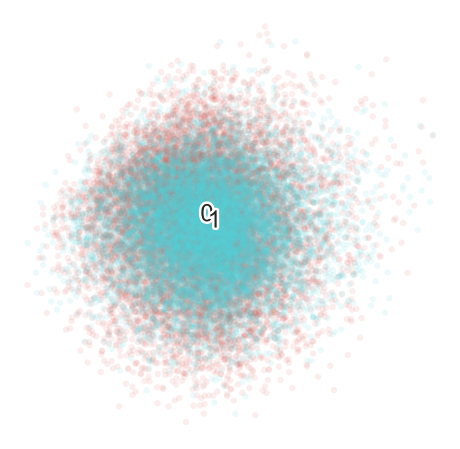

In [26]:
top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component

fashion_scatter(top_two_comp.values,y)

As the first 2 principle directions only captured about 30% of the data variance, the cats and dogs are not so distinct from each other from the 2D scatter plot using only the first 2 principle directions. Still, we can see some degree of difference as the blue points are more densely packed. 

#### t-SNE first attempt

<font color = red> Note: Time taken to run the block below is approximately 1 hour! <font>

In [27]:
#implement t-SNE

time_start = time.time()

fashion_tsne = TSNE(random_state=RS).fit_transform(x)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 3630.260908603668 seconds


(<Figure size 576x576 with 1 Axes>,
 [Text(-2.0046482, 0.7533542, '0'), Text(2.7584233, -0.8747039, '1')])

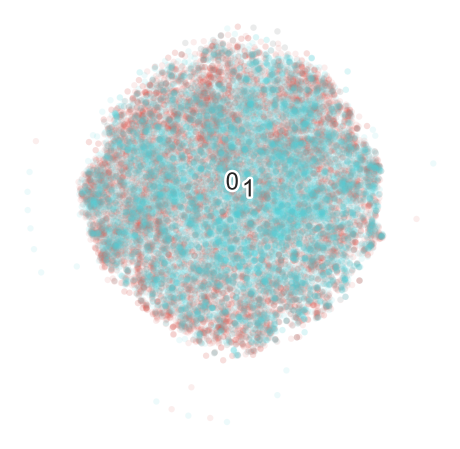

In [28]:
fashion_scatter(fashion_tsne, y)

With t-SNE, cats and dogs still cannot be seperated effectively. It seems that it is not possible to distiguish cats and dogs from just a 2D figure.

#### t-SNE second attempt

Before we implement the t-SNE algorithm this time, We first reduced the number of dimensions using PCA from 3600 to 407. This will suppress some noise and speed up the computation of pairwise distances between samples. 

In [29]:
time_start = time.time()

pca_407 = PCA(n_components=407)
pca_result_407 = pca_407.fit_transform(x)

print('PCA with 407 components done! Time elapsed: {} seconds'.format(time.time()-time_start))

print('Cumulative variance explained by 407 principal components: {}'.format(np.sum(pca_407.explained_variance_ratio_)))

PCA with 407 components done! Time elapsed: 8.73111629486084 seconds
Cumulative variance explained by 407 principal components: 0.8993567397889733


In [30]:
time_start = time.time()


fashion_pca_tsne = TSNE(random_state=RS).fit_transform(pca_result_407)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 537.4890966415405 seconds


(<Figure size 576x576 with 1 Axes>,
 [Text(0.5769438, -2.5581474, '0'), Text(-0.8302108, 1.4361212, '1')])

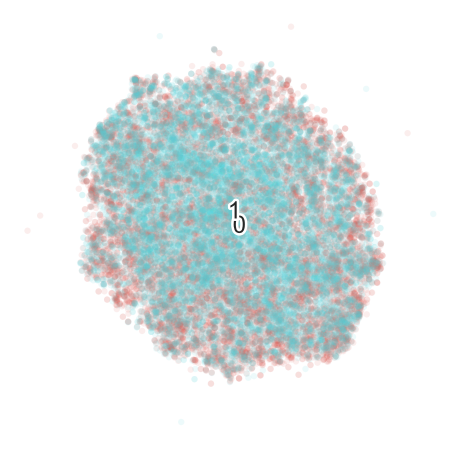

In [31]:
fashion_scatter(fashion_pca_tsne, y)

The second t-SNE figure is very similiar to the first one. However by performing PCA to reduce the number of dimension from 3600 to 407, we are able to reduce running time of t-SNE from 3600s to 500s. T-SNE is a none-linear algorithm unlike PCA, which is linear, and t-SNE takes much longer to run. It is therefore a good practise to use PCA to reduce the number of dimensions to a reasonable amount if the number of dimensions is very high. This will speed up the computation time of t-SNE.

# Data Preprocessing
[Back to top](#Contents)<br>

In [3]:
seed = 5
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed**2)
    torch.manual_seed(seed**3)
    torch.cuda.manual_seed(seed**4)
set_random_seed(seed)

train_dir = 'train'
test_dir = 'test'

train_list = glob.glob(os.path.join(train_dir, '*.jpg'))
train_index = np.arange(len(train_list))
np.random.shuffle(train_index)

train_list = [train_list[i] for i in train_index[:3000]]

train_list, val_list = train_test_split(train_list, test_size=0.1, random_state = seed)

class ImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

class SubDogvsCatDataset():
    
    def __init__(self, file_list, transform = None, phase='train'):
        self.transform = transform
        self.data = []
        self.targets = []

        for img_path in file_list:
            img = Image.open(img_path)
            img_transformed = self.transform(img, phase)

            label = img_path.split('.')[0][-3:]

            if label == 'dog':
                label = 1
            elif label == 'cat':
                label = 0
            self.data.append(img_transformed.numpy())
            self.targets.append(label)

        self.data = np.array(self.data)
        self.targets = np.array(self.targets)

def draw_curve(train_loss, val_loss, train_acc, val_acc):
    fig = plt.figure()
    ax0 = fig.add_subplot(121, title="loss")
    ax1 = fig.add_subplot(122, title="acc")
    x_epoch = list(range(len(train_acc)))
    ax0.plot(x_epoch, train_loss, 'bo-', label='train')
    ax0.plot(x_epoch, val_loss, 'ro-', label='val')
    ax1.plot(x_epoch, train_acc, 'bo-', label='train')
    ax1.plot(x_epoch, val_acc, 'ro-', label='val')
    ax0.legend()
    ax1.legend()
    fig.savefig('train.png')
    plt.close('all')

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

size = 64
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Process Train
train_dataset = SubDogvsCatDataset(train_list, ImageTransform(size, mean, std), 'train')
train_data, train_target = train_dataset.data, train_dataset.targets

train_dic = {'data': train_data, 'target': train_target}

with open('train_data.json', 'w') as fp:
    json.dump(train_dic, fp, cls=NumpyEncoder)
print('Train Data Saved Successfully with Train Shape', train_data.shape)

#Process Val
val_dataset = SubDogvsCatDataset(val_list, ImageTransform(size, mean, std), 'val')
val_data, val_target = val_dataset.data, val_dataset.targets

val_dic = {'data': val_data, 'target': val_target}

with open('val_data.json', 'w') as fp:
    json.dump(val_dic, fp, cls=NumpyEncoder)
print('Val Data Saved Successfully with Val Shape', val_data.shape)

Train Data Saved Successfully with Train Shape (2700, 3, 64, 64)
Val Data Saved Successfully with Val Shape (300, 3, 64, 64)


In [4]:
#load preprocessed train/val data
with open('train_data.json', 'r') as fp:
    train_dic = json.load(fp)
    
train_data, train_target = np.asarray(train_dic['data']), np.asarray(train_dic['target'])
print('Train Data Loaded with shape', train_data.shape)

original_train_shape = train_data.shape
train_data = train_data.reshape(train_data.shape[0], -1)
print('After Reshape:', train_data.shape)

with open('val_data.json', 'r') as fp:
    val_dic = json.load(fp)
    
val_data, val_target = np.asarray(val_dic['data']), np.asarray(val_dic['target'])
print('Val Data Loaded with shape', val_data.shape)

original_val_shape = val_data.shape
val_data = val_data.reshape(val_data.shape[0], -1)
print('After Reshape:', val_data.shape)

Train Data Loaded with shape (2700, 3, 64, 64)
After Reshape: (2700, 12288)
Val Data Loaded with shape (300, 3, 64, 64)
After Reshape: (300, 12288)


# SVM
[Back to top](#Contents)<br>

In [5]:
start = time.time()
svm = SVC(gamma='auto')
obj = svm.fit(train_data, train_target)
print('SVM Time Elapsed =', time.time()-start)
print('SVM Train Acc =', obj.score(train_data, train_target))
print('SVM Val Acc =', obj.score(val_data, val_target))

SVM Time Elapsed = 93.03402185440063
SVM Train Acc = 0.8948148148148148
SVM Val Acc = 0.5166666666666667


# Logistic Regression
[Back to top](#Contents)<br>

In [6]:
start = time.time()
lr = LogisticRegression(random_state=seed)
obj = lr.fit(train_data, train_target)
print('LR Time Elapsed =', time.time()-start)
print('LR Train Acc =', obj.score(train_data, train_target))
print('LR Val Acc =', obj.score(val_data, val_target))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR Time Elapsed = 2.6309304237365723
LR Train Acc = 0.9729629629629629
LR Val Acc = 0.5233333333333333


# Random Forest
[Back to top](#Contents)<br>

In [7]:
start = time.time()
rf = RandomForestClassifier(random_state=seed)
obj = rf.fit(train_data, train_target)
print('RF Time Elapsed =', time.time()-start)
print('RF Train Acc =', obj.score(train_data, train_target))
print('RF Val Acc =', obj.score(val_data, val_target))

RF Time Elapsed = 13.703354120254517
RF Train Acc = 1.0
RF Val Acc = 0.5066666666666667


# KNN
[Back to top](#Contents)<br>

In [8]:
start = time.time()
knn = KNeighborsClassifier()
obj = knn.fit(train_data, train_target)
print('KNN Time Elapsed =', time.time()-start)
print('KNN Train Acc =', obj.score(train_data, train_target))
print('KNN Val Acc =', obj.score(val_data, val_target))

KNN Time Elapsed = 9.759938478469849
KNN Train Acc = 0.6955555555555556
KNN Val Acc = 0.5633333333333334


# Ridge
[Back to top](#Contents)<br>

In [9]:
start = time.time()
ridge = Ridge()
obj = ridge.fit(train_data, train_target)
print('Ridge Time Elapsed =', time.time()-start)

prediction = np.array(obj.predict(train_data)>0.5, dtype = int)
train_acc = accuracy_score(train_target, np.array(prediction).reshape(-1,1))
print('Ridge Train Acc =', train_acc)

prediction = np.array(obj.predict(val_data)>0.5, dtype = int)
val_acc = accuracy_score(val_target, np.array(prediction).reshape(-1,1))
print('Ridge Val Acc =', val_acc)

Ridge Time Elapsed = 1.0791137218475342
Ridge Train Acc = 1.0
Ridge Val Acc = 0.5666666666666667


# Neural Network
[Back to top](#Contents)<br>

<font color = red> Note: There was a run-time error when we ran Neural Network because of insufficient CPU memory. We solved this problem by restarting the ipyn file and start running the file from the Neural Network code below onwards. (meaning we skipped all the previous parts in the second run)<font>

In [10]:
#customize dataset
class TransformDataset(Dataset):
    def __init__(self,images,labels):
        self.data=torch.Tensor(images)
        self.targets=torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample=self.data[idx]
        target=self.targets[idx]
        return sample,target

#define train function
def train_model(net, dataloader_dict, criterion, optimizer, num_epoch):
    
    since = time.time()
    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:

            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            if phase=='train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    net.load_state_dict(best_model_wts)
    return net


#NN setting
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data = train_data.reshape(original_train_shape)
val_data = val_data.reshape(original_val_shape)

train_dataset = TransformDataset(train_data, train_target)
val_dataset = TransformDataset(val_data, val_target)

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

#VGG16
num_epoch = 1
size = 64

net = torchvision.models.vgg16(pretrained = True)
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
update_params_name = ['classifier.6.weight', 'classifier.6.bias']

net.to(device)

params_to_update = []
for name, param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

train_loss,val_loss,train_acc,val_acc = [],[],[],[]
net = train_model(net, dataloader_dict, criterion, optimizer, num_epoch)

classifier.6.weight
classifier.6.bias
Epoch 1/1
--------------------



train Loss: 0.6278 Acc: 0.8367



val Loss: 0.5696 Acc: 0.8033
Training complete in 0m 6s
Best val Acc: 0.803333


# Neural Network Full Dataset
[Back to top](#Contents)<br>

In [7]:
train_dir = 'train'
test_dir = 'test'

train_list = glob.glob(os.path.join(train_dir, '*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

train_list, val_list = train_test_split(train_list, test_size=0.1)
    

class DogvsCatDataset(data.Dataset):
    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        # Get Label
        label = img_path.split('.')[0][-3:]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

def train_model(net, dataloader_dict, criterion, optimizer, num_epoch):
    
    since = time.time()
    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:
            
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            batch = 0
            for inputs, labels in tqdm(dataloader_dict[phase]):
                print(labels)
                print(batch)
                batch+=1
                
                inputs = inputs.to(device)
                labels = labels.long().to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    net.load_state_dict(best_model_wts)
    return net

size = 224

#ImageNet Mean & Std
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

batch_size =32

#device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = DogvsCatDataset(train_list, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_list, transform=ImageTransform(size, mean, std), phase='val')

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
net.to(device)

params_to_update = []
for name, param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

num_epoch = 1
net = train_model(net, dataloader_dict, criterion, optimizer, num_epoch)

classifier.6.weight
classifier.6.bias
Epoch 1/1
--------------------


tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0])
0
tensor([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 1])
1
tensor([1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 0, 0, 0])
2
tensor([1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 0])
3
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 1])
4
tensor([0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 0])
5
tensor([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 1])
6
tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1])
7
tensor([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,


tensor([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0])
0
tensor([0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 1])
1
tensor([0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 0])
2
tensor([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 1])
3
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 0, 1])
4
tensor([0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 1, 0, 1, 0])
5
tensor([1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 1])
6
tensor([0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 0])
7
tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,


# Neural Network Prediction Results
[Back to top](#Contents)<br>

#### Predict and submit for competition with all test data

In [9]:
id_list = []
pred_list = []

net.eval()
with torch.no_grad():
    for test_path in tqdm(test_list):
        img = Image.open(test_path)
        _id = int(test_path[5:].split('.')[0])
        print(_id)

        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        net.eval()

        outputs = net(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        
        id_list.append(_id)
        pred_list.append(preds[0])
    
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('submission.csv', index=False)

1
10
100
1000
10000
10001
10002
10003
10004
10005
10006
10007
10008
10009
1001
10010
10011
10012
10013
10014
10015
10016
10017
10018
10019
1002
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
1003
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
1004
10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
1005
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
1006
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
1007
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
1008
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
1009
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
101
1010
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
1011
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
1012
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
1013
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
1014
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
1015
10150
1

1252
1253
1254
1255
1256
1257
1258
1259
126
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
127
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
128
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
129
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
13
130
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
131
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
132
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
133
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
134
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
135
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
136
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
137
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
138
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
139
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
14
140
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
141
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
142
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
143
1430
1431
1432
1433
1434
1435
14

4268
4269
427
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
428
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
429
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
43
430
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
431
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
432
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
433
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
434
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
435
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
436
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
437
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
438
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
439
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
44
440
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
441
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
442
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
443
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
444
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
445
4450
445

7284
7285
7286
7287
7288
7289
729
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
73
730
7300
7301
7302
7303
7304
7305
7306
7307
7308
7309
731
7310
7311
7312
7313
7314
7315
7316
7317
7318
7319
732
7320
7321
7322
7323
7324
7325
7326
7327
7328
7329
733
7330
7331
7332
7333
7334
7335
7336
7337
7338
7339
734
7340
7341
7342
7343
7344
7345
7346
7347
7348
7349
735
7350
7351
7352
7353
7354
7355
7356
7357
7358
7359
736
7360
7361
7362
7363
7364
7365
7366
7367
7368
7369
737
7370
7371
7372
7373
7374
7375
7376
7377
7378
7379
738
7380
7381
7382
7383
7384
7385
7386
7387
7388
7389
739
7390
7391
7392
7393
7394
7395
7396
7397
7398
7399
74
740
7400
7401
7402
7403
7404
7405
7406
7407
7408
7409
741
7410
7411
7412
7413
7414
7415
7416
7417
7418
7419
742
7420
7421
7422
7423
7424
7425
7426
7427
7428
7429
743
7430
7431
7432
7433
7434
7435
7436
7437
7438
7439
744
7440
7441
7442
7443
7444
7445
7446
7447
7448
7449
745
7450
7451
7452
7453
7454
7455
7456
7457
7458
7459
746
7460
7461
7462
7463
7464
7465
7466
7467
74

We achieved an excellent competition score of 0.06848.

Our ranking is 161 out of the 1314 teams.

We are within the top 13%.

#### Prediction on some images

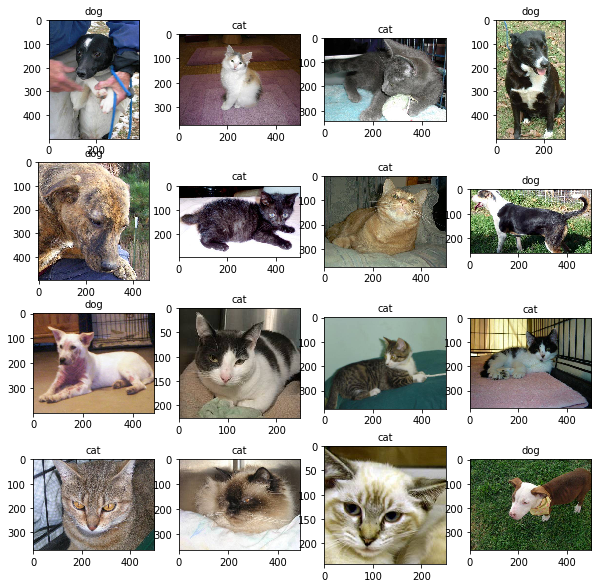

In [10]:
title_list = []
for result in pred_list[:16]:
    if int(round(result)) == 0:
        title_list.append('cat')
    else:
        title_list.append('dog')
test_sample = np.array([np.array(Image.open(fname)) for fname in test_list[:16]])
display_image(test_sample,4,4,title_list)

We predicted all the 16 images correctly. This together with our outstanding competiton results, showed that our neural network model trained with the full dataset is very sucessfull, and we achieved our goal of developing an accurate binary classification model to predict cats and dogs based on images from Kaggle